# Entrenamiento de Multiperceptrón con Dataset de Manos
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [2]:
MNT_DRIVE_DIR = '/content/drive/'
DRIVE_DIR = '/content/drive/MyDrive/'
DATOS_DIR = DRIVE_DIR + 'Datos/'
FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Fuentes'

from google.colab import drive
drive.mount(MNT_DRIVE_DIR)

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


**Carga del dataset de manos**

---



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics, model_selection

from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import seaborn as sns

# %% CARGA DE DATASET
nom_archivo = DATOS_DIR + 'Fingers/fingers_train.csv'
datos = pd.read_csv(nom_archivo)

# separa características y clase
X = np.array(datos.iloc[:, :-1])
Y = np.array(datos.iloc[:, -1])
nomClases = datos.iloc[:, -1].value_counts()

# Target codificado como one-hot
encoder = preprocessing.LabelEncoder()
Y_nro = encoder.fit_transform(Y)
Y_bin= to_categorical(Y_nro)

# %% --- CONJUNTOS DE ENTRENAMIENTO Y VALIDACION ---
X_train, X_val, Y_train, Y_val = model_selection.train_test_split( \
                                         X, Y_bin, test_size=0.20) #, random_state=42)

normalizador = preprocessing.StandardScaler()
X_train = normalizador.fit_transform(X_train)
X_val = normalizador.transform(X_val)
 

**Construye Modelo**

In [4]:
ENTRADAS = X_train.shape[1]
SALIDAS = Y_train.shape[1]
OCULTAS = 8
EPOCAS = 100
PACIENCIA = 10
ACTIVACION = 'tanh'
OPTIMIZADOR = 'adam'

# %% CONSTRUCCION DEL MODELO
model = Sequential()
model.add(Dense(OCULTAS, input_shape=[ENTRADAS], activation=ACTIVACION))
model.add(Dense(SALIDAS, activation='softmax'))
model.summary()  #-- muestra la cantidad de parámetros de la red


#-- se utilizará SGD (descenso de gradiente esticástico),
#-- MSE (error cuadrático medio) y ACCURACY como medida de performance
model.compile(optimizer=OPTIMIZADOR, loss='categorical_crossentropy', metrics=['accuracy'])
# %% ENTRENAMIENTO

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# entrena el modelo y guarda la historira del progreso    
history = model.fit(X_train,Y_train, epochs=EPOCAS, validation_data = (X_val, Y_val), callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
450/450 [==============================] - 2s 2ms/step - loss: 1.2496 - accuracy: 0.5442 - val_loss: 0.8106 - val_accuracy: 0.7175
Epoch 2/100
450/450 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.7842 - val_loss: 0.5653 - val_accuracy: 0.8156
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 0.5013 - accuracy: 0.8507 - val_loss: 0.4364 - val_accuracy: 0.8850
Epoch 4/100
450/450 [====

**Metricas y Gráficos**

450/450 [==============================] - 1s 1ms/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_train : 99.167%
Reporte de métricas de entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2419
           1       0.99      1.00      0.99      2388
           2       0.98      0.98      0.98      2393
           3       0.99      0.98      0.98      2405
           4       1.00      1.00      1.00      2397
           5       1.00      1.00      1.00      2397

    accuracy                           0.99     14399
   macro avg       0.99      0.99      0.99     14399
weighted avg       0.99      0.99      0.99     14399

113/113 [==============================] - 0s 1ms/step

 -------------------------------------------------------------------------------- 

Porcentaje de aciertos X_val : 99.028%
Reporte de métricas de validación:
              precision 

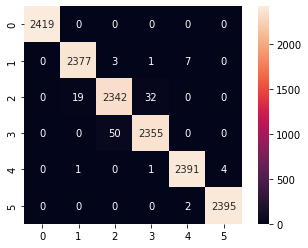

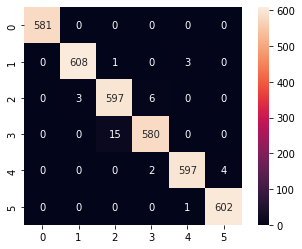

In [5]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- conversión a entero

Y_true = np.argmax(Y_train,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_train : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de entrenamiento:\n%s" % report)
cm = metrics.confusion_matrix(Y_true, Y_pred_nro)

plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

# %% --- VALIDACION ---
Y_pred = model.predict(X_val)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- conversión a entero

Y_true = np.argmax(Y_val,axis=1)
print('\n','-'*80, '\n')
print("Porcentaje de aciertos X_val : %.3f%%" % (100*metrics.accuracy_score(Y_true, Y_pred_nro)))

report = metrics.classification_report(Y_true, Y_pred_nro)
print("Reporte de métricas de validación:\n%s" % report)

cm = metrics.confusion_matrix(Y_true, Y_pred_nro)
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

**Gráficos con evolución de curvas de loss y accuracy**




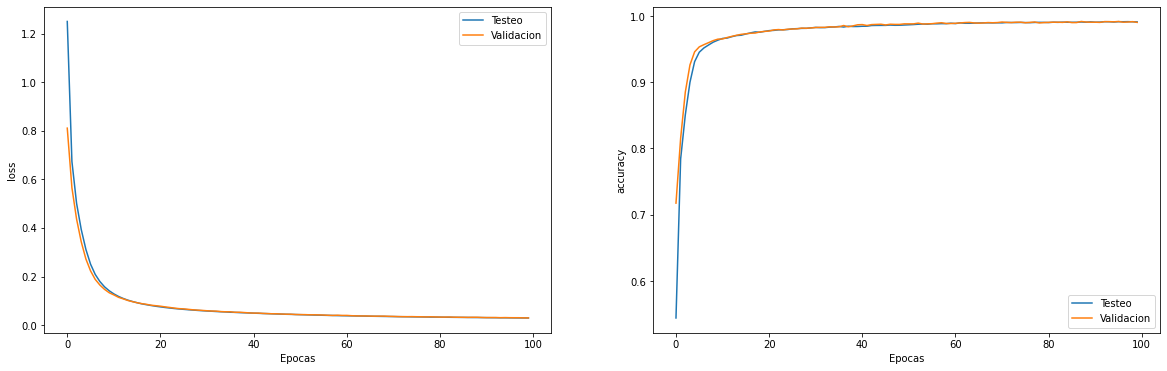

In [6]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()
    
fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'loss', history.epoch, hist)
dibujar_curva(axs[1], 'accuracy', history.epoch, hist)
